In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier # 결정트리 분류모델
from xgboost import XGBClassifier, plot_importance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [16]:
import pickle
with open('20240608_KOSPI.dat', 'rb') as f:
    pkl_data = pickle.load(f)

In [279]:
samsung = pd.DataFrame(pkl_data[0][2])
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 2000-02-15 to 2024-06-07
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


In [188]:
# Date -> to_numpy
#samsung=samsung.reset_index() # samsung.set_index("Date")
#samsung["Date"]=samsung["Date"].to_numpy()
samsung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   6000 non-null   int64         
 1   Date    6000 non-null   datetime64[ns]
 2   Open    6000 non-null   int64         
 3   High    6000 non-null   int64         
 4   Low     6000 non-null   int64         
 5   Close   6000 non-null   int64         
 6   Volume  6000 non-null   int64         
 7   Change  5999 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 375.1 KB


In [289]:
#for i in range(len(pkl_data)):
for i in range(0,5):
    print(pkl_data[i][0], pkl_data[i][1])
    pass

005930 삼성전자
000660 SK하이닉스
373220 LG에너지솔루션
005380 현대차
207940 삼성바이오로직스


rf.oob_score_ : 0.9991954613333937
rf.predict([a]) : [77937.]


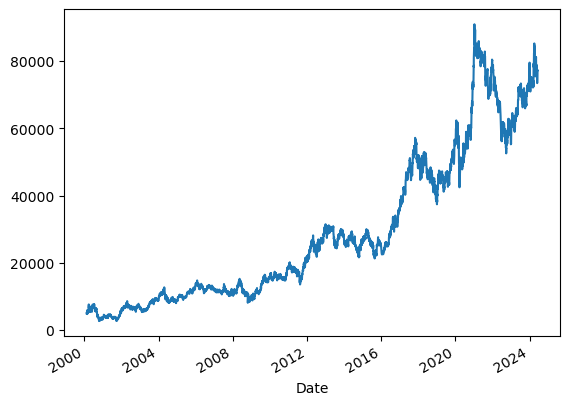

In [285]:
samsung = samsung.dropna()
samsung['Close'].plot()

X, Y = [], []

for i in range(len(samsung)-1):
    a = samsung.iloc[i].to_numpy()
    b = samsung.iloc[i+1]['Close']
    
    X.append(a) # 문제지 (당일 데이터)
    Y.append(b) # 답안지 (다음날 종가)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(oob_score=True)
rf.fit(X,Y)
print("rf.oob_score_ :", rf.oob_score_)

a = samsung.iloc[-1].to_numpy()
print("rf.predict([a]) :", rf.predict([a]))

In [407]:
# 하루에 5% 오르면 승, 아니면 패
from tqdm import tqdm

total_reward = 0 
total_rewards = []
count = 0
rates = []

for i in tqdm(pkl_data):
    code = i[0]
    name = i[1]
    df = i[2].dropna()
    Q = 0
    
    for j in range(len(df)-1):
        if df.iloc[j]['Close'] * 1.05 <= df.iloc[j+1]['Close']: # 5% 상승 대상
            reward =1
        else: reward=0
        
        if Q > 0.9:
            if reward == 1:
                total_reward += 1
            count += 1
            rates.append(total_reward / count)
        
        # 최신 정보에 더 가중치를 줄 수 있는 방법
        Q = (reward - Q) * 0.8 + Q
    

100%|██████████| 953/953 [08:07<00:00,  1.95it/s]


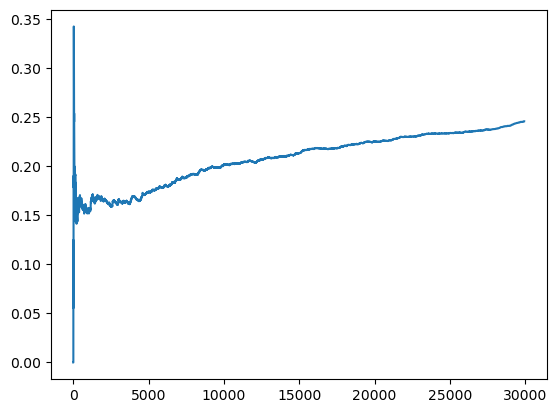

In [409]:
plt.plot(rates)

In [413]:
import sqlite3

conn = sqlite3.connect('stock.db')
for i in pkl_data:
    code = i[0]
    name = i[1]
    df = i[2].dropna()
    
    df.to_sql(name, conn, if_exists='replace')
    
conn.close()

In [423]:
conn = sqlite3.connect("stock.db")
query1 = """SELECT name FROM sqlite_master WHERE type='table'; """
query2 = """SELECT * FROM '삼성전자'; """
names = pd.read_sql_query(query1, conn)
df = pd.read_sql_query(query2, conn)
conn.close()
names
df

,Date,Open,High,Low,Close,Volume,Change
0,2000-02-16 00:00:00,5180,5200,4780,5000,1462389,-0.038462
1,2000-02-17 00:00:00,4939,5099,4910,5080,1303738,0.016000
2,2000-02-18 00:00:00,5370,5630,5160,5300,2175083,0.043307
3,2000-02-21 00:00:00,5200,5260,5030,5070,529722,-0.043396
4,2000-02-22 00:00:00,5000,5240,5000,5120,483669,0.009862
...,...,...,...,...,...,...,...
5994,2024-05-31 00:00:00,74500,74700,73500,73500,26198776,0.000000
5995,2024-06-03 00:00:00,74400,76400,74200,75700,15706268,0.029932
5996,2024-06-04 00:00:00,74900,76100,74900,75300,14098053,-0.005284
5997,2024-06-05 00:00:00,78000,78000,76800,77400,23177968,0.027888


In [ ]:
########################################################

In [102]:
rate = np.random.rand() # 0~1 사이의 랜덤값
rate

0.8422730298093464

In [104]:
total_reward = []
for i in range(10000):
    if rate > np.random.rand():
        total_reward.append(1)

In [118]:
sum(total_reward) / 10000 * 100

84.58

In [149]:
Q=0
for n in range(1, 10000):
    if rate > np.random.rand():
        reward = 1
    else: reward = 0
    
    Q = (reward - Q) / n + Q
Q

0.8408840884088394

In [361]:
# 게임기 10대
class Game:
    def __init__(self, arms = 10):
        self.rates = np.random.rand(arms)

    def play(self, arm):
        rate = self.rates[arm]
        if rate > np.random.rand():
            return 1
        else:
            return 0
        
game = Game()
game.rates

array([0.31884225, 0.04466051, 0.86640631, 0.85031743, 0.74601572,
       0.15882878, 0.22401121, 0.00120198, 0.90752714, 0.24367472])

In [179]:
for i in range(10):
    a = game.play(1)
    print(a)

1
0
0
1
0
1
1
1
0
0


In [184]:
Qs = np.zeros(10) # 게임기 확률
Ns = np.zeros(10) # 게임기를 이용한 횟수

In [297]:
game = Game()

Qs = np.zeros(10) # 게임기 확률
Ns = np.zeros(10) # 게임기 이용한 횟수

total_reward = 0

for n in range(10000):
    
    action = np.random.randint(0, 10) # 0~9까지 랜덤으로 정수 하나
    reward = game.play(action)

    total_reward += reward
    
    Ns[action] += 1
    Qs[action] = (reward - Qs[action]) / Ns[action] + Qs[action]

In [299]:
print(Qs)
print(game.rates)

[0.24791667 0.79484536 0.78171091 0.76315789 0.64728682 0.72407045
 0.43849206 0.24721378 0.63517588 0.38981391]
[0.25583097 0.78194901 0.77499135 0.73207002 0.64300365 0.70549127
 0.42443243 0.25085753 0.62108039 0.37667408]


In [372]:
class Person:
    def __init__(self):
        self.Qs = np.zeros(10)
        self.Ns = np.zeros(10)
    
    def update(self, action, reward):
        self.Ns[action] += 1
        self.Qs[action] += (reward - self.Qs[action]) / self.Ns[action]
    
    # 확률 높은 게임기로 해봐. 근데 가끔씩 더 좋은게 있는 지 탐색도 해
    # 90%% 확률로는 확률높은게임기, 10% 확률로는 탐색
    def get_action(self):
        if np.random.rand() < 0.1:
            return np.random.randint(0,10)
        else: np.argmax(self.Qs)

In [374]:
steps = 10000

game = Game() # 오락실
person = Person() # 사람

total_reward = 0
total_rewards = []
rates = []

for step in range(steps):
    
    action = person.get_action()
    reward = game.play(action)
    
    person.update(action, reward)
    total_reward += reward

    total_rewards.append(total_reward)
    rates.append(total_reward / (step + 1)) # 승률 기록

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#################################

In [345]:
bike_dt = pd.DataFrame(pd.read_csv("bike.csv"))
bike_dt = bike_dt.dropna()
bike_dt

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [355]:
bike_dt['datetime'] = pd.to_datetime(bike_dt['datetime'])
bike_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


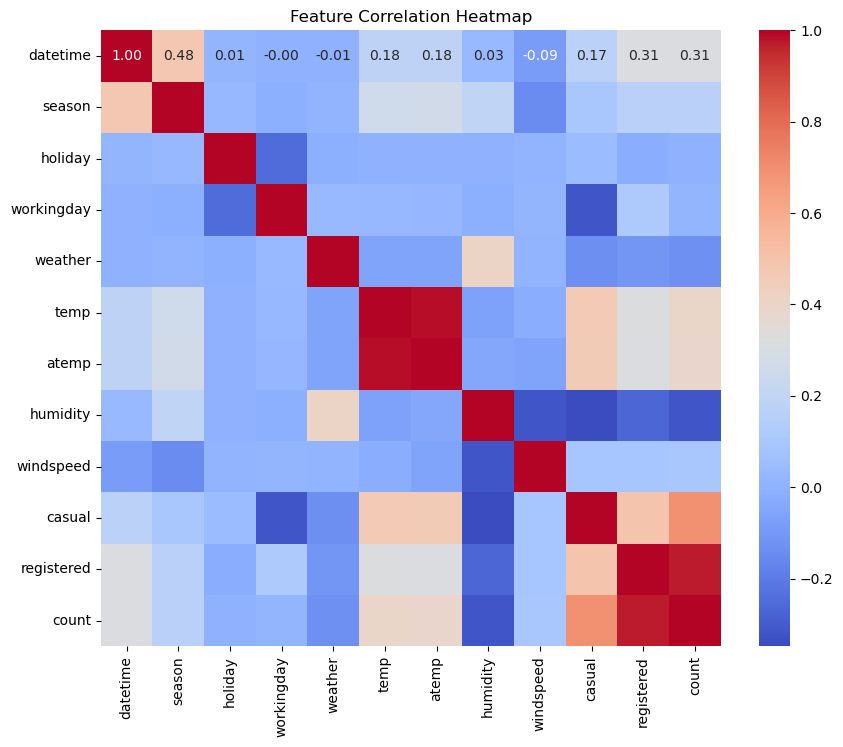

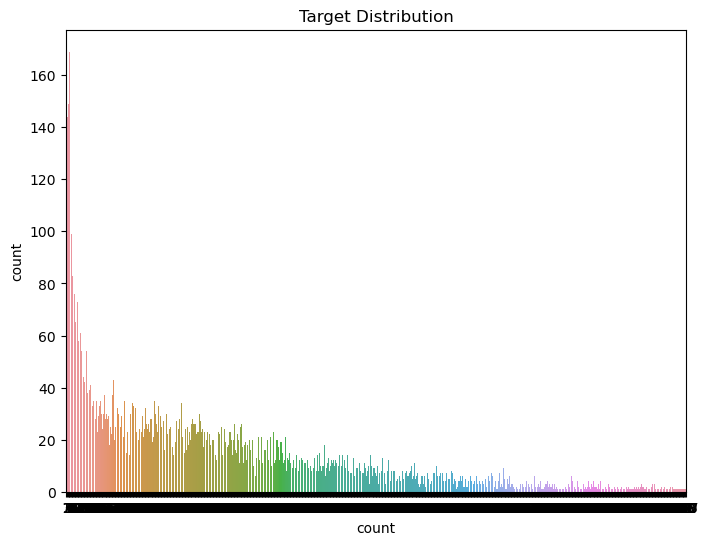

In [366]:
# 특성과 타겟 분리
X = bike_dt.drop('count', axis=1).drop('datetime', axis=1).values
y = bike_dt['count'].values

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 특성 상관 관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(bike_dt.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 타겟 분포
plt.figure(figsize=(8, 6))
sns.countplot(x='count', data=bike_dt)
plt.title('Target Distribution')
plt.show()

In [521]:
# RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rfr.fit(X_train, y_train) # 스케일링 필요없음
print(rfr.score(X_test, y_test))
print(f"Random Forest Regressor oob_score_: {rfr.oob_score_}")
y_pred = rfr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest Regressor Mean Squared Error: {mse}")

0.9997253609077605
Random Forest Regressor oob_score_: 0.9996746139238297
Random Forest Regressor Mean Squared Error: 9.064994903581269


[2.14997821e-05 2.77105078e-06 8.69452300e-06 1.72732724e-05
 5.22822398e-05 5.21378506e-05 8.08996484e-05 6.77054211e-05
 5.22655616e-02 9.47431175e-01]


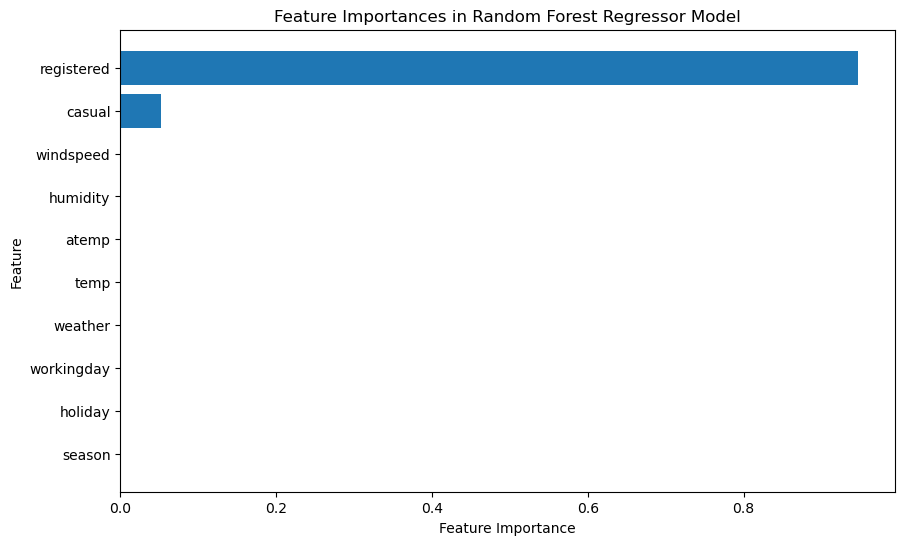

In [474]:
# 중요 특징 시각화
feature_importances = rfr.feature_importances_
print(feature_importances)
features = bike_dt.drop('count', axis=1).drop('datetime', axis=1).columns.tolist()
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Regressor Model')
plt.show()

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaledled, y_train)
dt.score(X_test_scaled, y_test)

from sklearn.tree import plot_tree 
plt.figure(figsize=[15,15])
plot_tree(dt, feature_names=bike_dt.drop('count', axis=1).drop('datetime', axis=1).columns.tolist(), filled=True)

In [495]:
from konlpy.tag import Kkma, Okt #형태소분석기
import pandas as pd
from collections import Counter 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

kkma = Kkma() #형태소분석기 kkma 정의
okt = Okt()
dic = Counter()

In [503]:
kkma.nouns("아버지 가방에 들어가신다")

['아버지', '가방']

In [504]:
okt.nouns("아버지가 방에 들어가신다")

['아버지', '방']